In [17]:
import numpy as np
import csv
import json

# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

# GeoTiff Images
import rasterio

# Visualisation
from matplotlib import pyplot as plt
import matplotlib.image as img
from matplotlib.pyplot import figure
from PIL import Image

# Others
import os
import shutil
import zipfile

from tqdm import tqdm
import glob

# Deep learning framework 
import tensorflow as tf 


In [18]:
# List all physical devices of type GPU
gpus = tf.config.list_physical_devices('GPU')
print("GPUs Available: ", gpus)

GPUs Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [20]:
# Open the geotiff file
import re 
def extract_title_ij(filename):
    pattern_base = r"(\w+)/tile_(\d+)_(\d+).jpg"
    pattern_mask = r"(\w+)/tile_(\d+)_(\d+)_mask.jpg"
    match_base = re.search(pattern_base, filename)
    match_mask = re.search(pattern_mask, filename)
    if match_base:
        title , i, j = map(str, match_base.groups())
        return title, i, j
    if match_mask:
        title , i, j = map(str, match_mask.groups())
        return title, i, j
    return None, None, None

def load_and_visualize(image_path):
    """
    display a tif image (little tiles are recommended)
    """
    with rasterio.open(image_path) as src:
        # Read the red, green, and blue bands directly into a 3D array
        image_rgb = src.read([1, 2, 3])  # Read bands 1, 2, and 3 in a single call
        # Transpose the array for correct display (optional)
        image_rgb = image_rgb.transpose(1, 2, 0)

        title , i, j = extract_title_ij(image_path)

        # Display the RGB composite image
        plt.imshow(image_rgb)
        plt.title(f"Image from {title} at position (i={i},j={j})")
        plt.show()

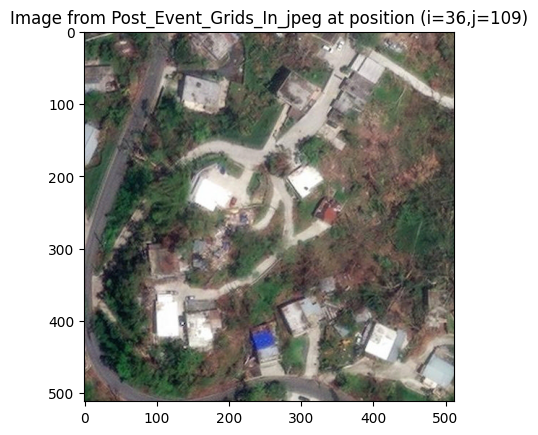

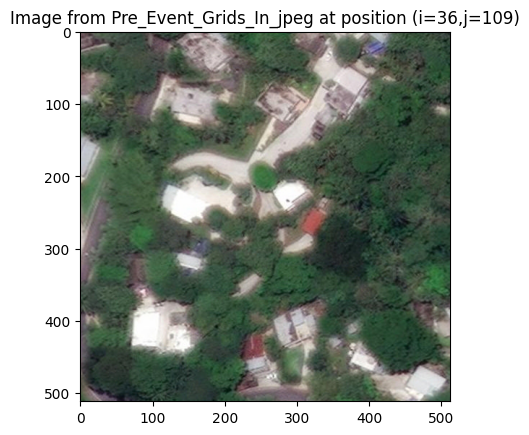

In [21]:
i = 36
j = 109

load_and_visualize(f"./data/Post_Event_Grids_In_jpeg/tile_{i}_{j}.jpg")
load_and_visualize(f"./data/Pre_Event_Grids_In_jpeg/tile_{i}_{j}.jpg")

In [51]:
data_dir = "./data"
img_height, img_width = 224, 224
batch_size = 32

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)
  
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 15440 files belonging to 2 classes.
Using 12352 files for training.
Found 15440 files belonging to 2 classes.
Using 3088 files for validation.


In [53]:
class_names = train_ds.class_names
print(class_names)

['Post_Event_Grids_In_jpeg', 'Pre_Event_Grids_In_jpeg']


In [23]:
#Define a dictionary to map the original class names to new ones
# Format: {original_class_name: new_class_name}
class_rename_map = {
    'Post_Event_Grids_In_jpeg': 'Post_disaster',
    'Pre_Event_Grids_In_jpeg': 'Pre_disaster'
}
# The new mapping of the class indices based on the renaming
new_class_names = [class_rename_map[cls] for cls in class_names]
train_ds.class_names = new_class_names
val_ds.class_names = new_class_names

In [54]:
print(new_class_names)

['Post_disaster', 'Pre_disaster']


2024-10-25 15:16:53.806760: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


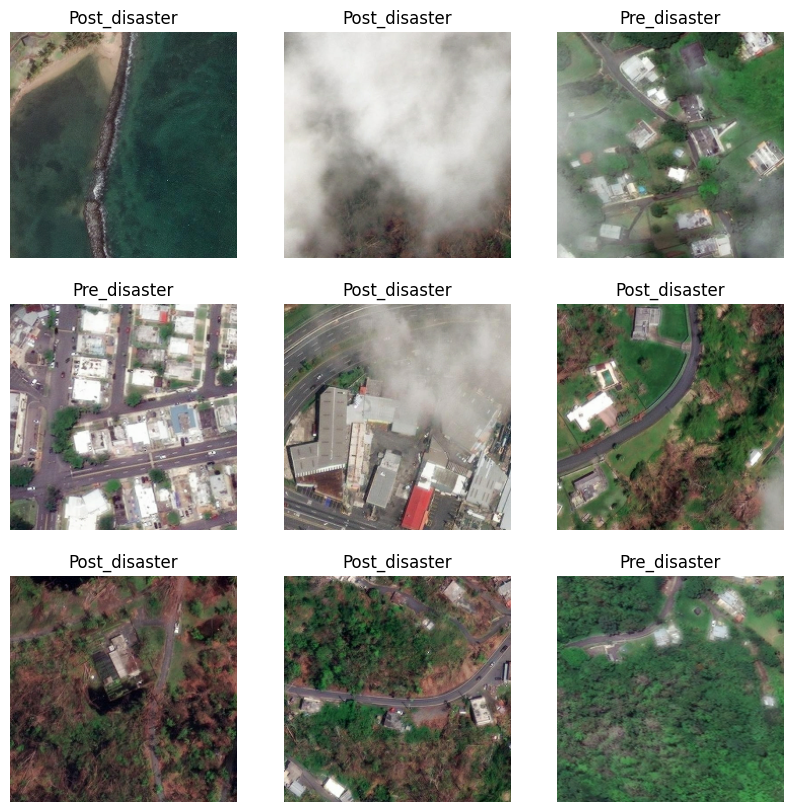

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(train_ds.class_names[labels[i]])
    plt.axis("off")

In [25]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


## Model Training 

In [26]:
for image_batch, labels_batch in train_ds.take(1):
  print(image_batch.shape)
  print(labels_batch)
  break

(32, 224, 224, 3)
tf.Tensor([0 0 0 0 1 0 1 0 0 0 1 1 0 0 1 1 1 1 1 0 0 1 1 0 1 1 0 0 0 1 1 1], shape=(32,), dtype=int32)


In [30]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, losses
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import datetime
import psutil
import GPUtil
import time

# Function to log system performance metrics
def log_system_metrics(step):
    # CPU and memory usage
    cpu_percent = psutil.cpu_percent()
    memory_info = psutil.virtual_memory().percent

    # GPU usage (if available)
    gpus = GPUtil.getGPUs()
    if gpus:
        gpu_load = gpus[0].load * 100  # Use the first GPU
        gpu_memory = gpus[0].memoryUtil * 100
    else:
        gpu_load = gpu_memory = 0  # No GPU available

    with system_writer.as_default():
        tf.summary.scalar("CPU Usage (%)", cpu_percent, step=step)
        tf.summary.scalar("RAM Usage (%)", memory_info, step=step)
        tf.summary.scalar("GPU Load (%)", gpu_load, step=step)
        tf.summary.scalar("GPU Memory (%)", gpu_memory, step=step)


# Set up GPU device if available
device = "/GPU:0" if tf.config.list_physical_devices('GPU') else "/CPU:0"
print(f"Training done on {device}")

#pre-porocess data 
train_ds = train_ds.shuffle(buffer_size=1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

# Load and modify a pretrained ResNet model
base_model = EfficientNetB3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze the base model

# Build the model
model = models.Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    base_model,
    layers.GlobalAveragePooling2D(), 
    layers.Dense(128, activation='relu'),
    layers.Dense(len(class_names), activation='softmax'),
])

# Compile the model with a loss function and optimizer
learning_rate = 0.001

model.compile(
    optimizer=optimizers.Adam(learning_rate=learning_rate),
    loss=losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

model.summary()


Training done on /GPU:0


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_11 (Rescaling)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb3 (Functional)     │ (None, 7, 7, 1536)     │    10,783,535 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 1536)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │       196,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,980,529 (41.89 MB)

 Trainable params: 196,994 (769.51 KB)

 Non-trainable params: 10,783,535 (41.14 MB)

In [31]:
# Set up TensorBoard logging
log_dir = "runs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
print(f"\nModel logs are available in {log_dir}")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# Train the model
epochs = 10
history = model.fit(
    train_ds,
    epochs=epochs,
    validation_data=val_ds,
    callbacks=[tensorboard_callback]
)


Model logs are available in runs/fit/20241025-152101
Epoch 1/10
386/386 ━━━━━━━━━━━━━━━━━━━━ 94s 149ms/step - accuracy: 0.5752 - loss: 0.6827 - val_accuracy: 0.5599 - val_loss: 0.6764
Epoch 2/10
386/386 ━━━━━━━━━━━━━━━━━━━━ 40s 97ms/step - accuracy: 0.6133 - loss: 0.6633 - val_accuracy: 0.6150 - val_loss: 0.6558
Epoch 3/10
386/386 ━━━━━━━━━━━━━━━━━━━━ 40s 98ms/step - accuracy: 0.6250 - loss: 0.6613 - val_accuracy: 0.6176 - val_loss: 0.6546
Epoch 4/10
386/386 ━━━━━━━━━━━━━━━━━━━━ 39s 97ms/step - accuracy: 0.6221 - loss: 0.6609 - val_accuracy: 0.6418 - val_loss: 0.6511
Epoch 5/10
386/386 ━━━━━━━━━━━━━━━━━━━━ 39s 96ms/step - accuracy: 0.6243 - loss: 0.6605 - val_accuracy: 0.6389 - val_loss: 0.6505
Epoch 6/10
386/386 ━━━━━━━━━━━━━━━━━━━━ 39s 96ms/step - accuracy: 0.6312 - loss: 0.6556 - val_accuracy: 0.6211 - val_loss: 0.6529
Epoch 7/10
386/386 ━━━━━━━━━━━━━━━━━━━━ 39s 95ms/step - accuracy: 0.6258 - loss: 0.6606 - val_accuracy: 0.6052 - val_loss: 0.6607
Epoch 8/10
386/386 ━━━━━━━━━━━━━━━━

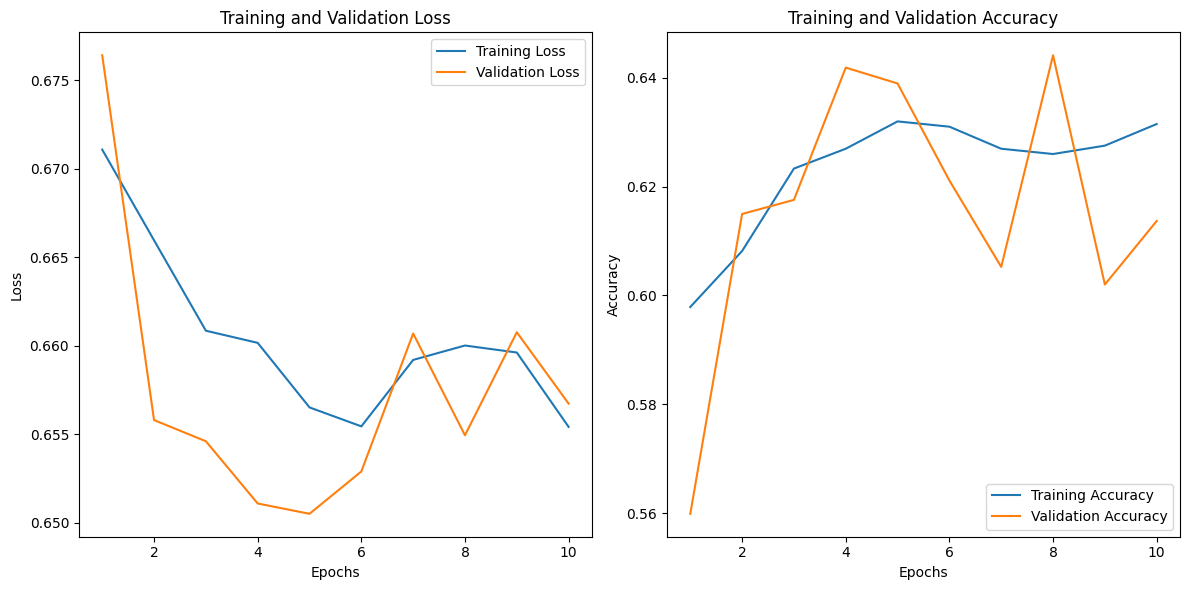

In [32]:
import matplotlib.pyplot as plt

# Extract metrics from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs_range = range(1, len(train_loss) + 1)

# Plot loss
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [42]:
for i, layer in enumerate(model.layers):
    print(f"layer {i} : {layer.name}")

layer 0 : rescaling_11
layer 1 : efficientnetb3
layer 2 : global_average_pooling2d_3
layer 3 : dense_6
layer 4 : dense_7


### Model Testing 

In [64]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    ConfusionMatrixDisplay,
    roc_curve,
    auc,
    f1_score,
)

def evaluate_model(model, test_ds, class_names):
    """
    Evaluates a classification model on a test dataset and computes the confusion matrix, AUC, and F1 Score.

    Parameters:
    - model: Trained TensorFlow/Keras model.
    - test_ds: tf.data.Dataset formatted test dataset with batches of (images, labels).
    - class_names: List of class names corresponding to label indices.

    Returns:
    - confusion_matrix: Numpy array representing the confusion matrix.
    - classification_report: Classification report containing precision, recall, F1-score.
    - AUC: Area under the ROC curve.
    - F1 Score: F1 Score of the model.
    """
    y_true = []
    y_pred = []
    y_probs = []  # To hold predicted probabilities for AUC calculation

    # Loop over the test dataset to gather true labels and predictions
    for images, labels in test_ds:
        # Get model predictions
        predictions = model.predict(images)
        predicted_classes = np.argmax(predictions, axis=1)
        
        # Append true labels and predicted labels
        y_true.extend(labels.numpy())
        y_pred.extend(predicted_classes)
        y_probs.extend(predictions[:, 1])  # Probability for the positive class (assuming binary classification)

    # Compute confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred)
    
    # Optional: Display a detailed classification report
    report = classification_report(y_true, y_pred, target_names=class_names)

    # Compute F1 Score
    f1 = f1_score(y_true, y_pred, average='weighted')  # Change to 'macro' if you prefer unweighted average
    
    # Compute ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(y_true, y_probs)
    auc_value = auc(fpr, tpr)

    print("Confusion Matrix:")
    print(conf_matrix)
    print("\nClassification Report:")
    print(report)
    print(f"F1 Score: {f1:.4f}")
    print(f"AUC: {auc_value:.4f}")

    # Display the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

    # Plot ROC Curve
    plt.figure()
    plt.plot(fpr, tpr, color='blue', label='ROC curve (area = {:.2f})'.format(auc_value))
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━

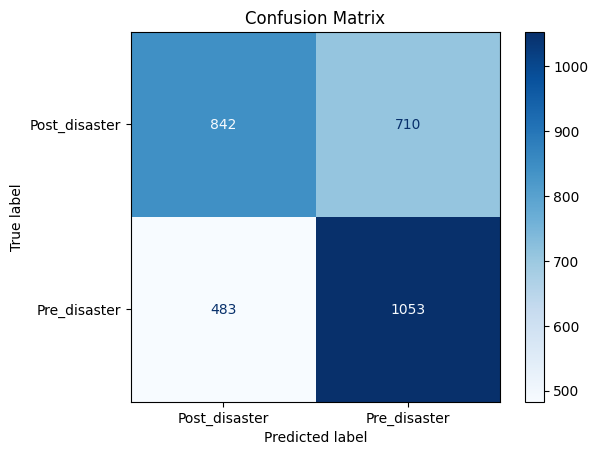

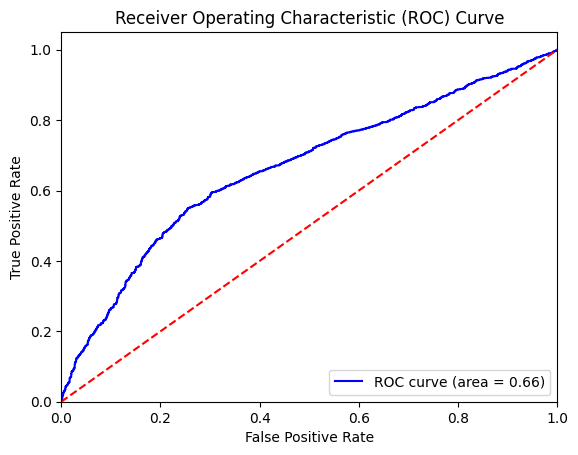

(array([[ 842,  710],
        [ 483, 1053]]),
 '               precision    recall  f1-score   support\n\nPost_disaster       0.64      0.54      0.59      1552\n Pre_disaster       0.60      0.69      0.64      1536\n\n     accuracy                           0.61      3088\n    macro avg       0.62      0.61      0.61      3088\n weighted avg       0.62      0.61      0.61      3088\n',
 0.6637063567171393,
 0.6117161861807794)

In [65]:
evaluate_model(model, val_ds, class_names = new_class_names)